In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd


def df_to_tensor(df: pd.DataFrame, dtype=float) -> torch.Tensor:
    return torch.Tensor(df.to_numpy(dtype=dtype))

def arr_to_tensor(arr):
    return torch.Tensor(arr).float()

def get_data(_n_points_per_group=None, filepath="data.pkl", input_cols=None, output_cols=None, return_full_data=False,):
    df = pd.read_pickle(filepath)
    if output_cols is None:
        output_cols = ['load_to_pred']
    if input_cols is None:
        input_cols = [col for col in df.columns
                      if col not in output_cols and not col.startswith('ts')]
        # input_cols = [
        #     'load_last_week',
        #     'load_yesterday',
        #     'load_last_hour',
        #     'is_workday',
        #     'is_saturday_and_not_holiday',
        #     'is_sunday_or_holiday',
        #     'is_heating_period',
        # ]

    lim = 2*_n_points_per_group if _n_points_per_group is not None else -1
    X = df[input_cols].iloc[:lim]
    y = df[output_cols].iloc[:lim]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, shuffle=False
    )
    if return_full_data:
        return X_train, X_test, y_train, y_test, X, y
    return X_train, X_test, y_train, y_test


def standardize(train_data, *arrays_to_standardize):
    # todo: also return scaler?
    scaler = StandardScaler()
    scaler.fit(train_data)
    return scaler, map(scaler.transform, [train_data, *arrays_to_standardize])

data shapes: torch.Size([800, 7]) torch.Size([800, 7]) torch.Size([800, 1]) torch.Size([800, 1])


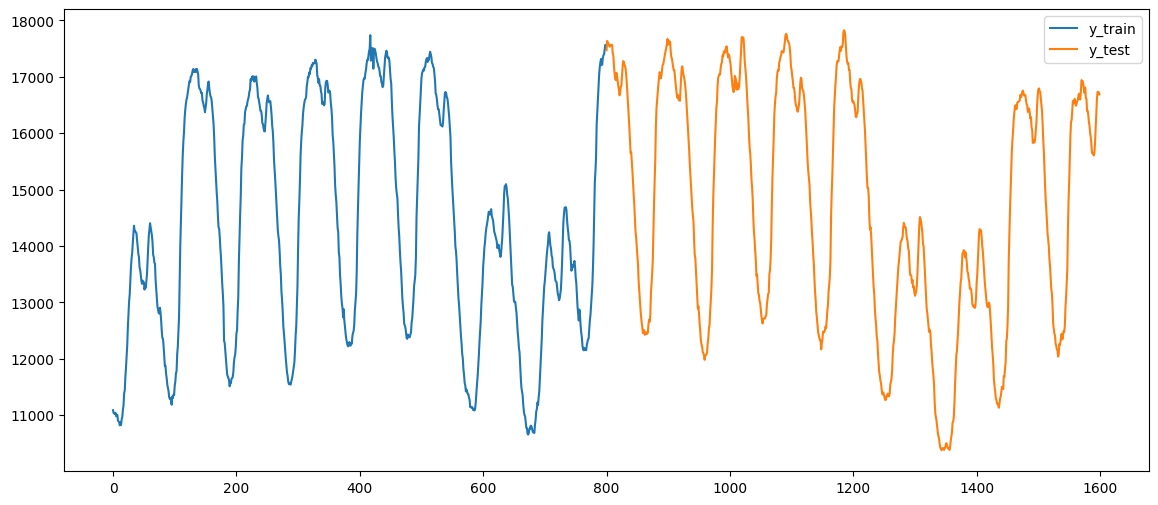

In [6]:
n_datapoints_per_group = 800
standardize_X = True
standardize_y = False

X_train, X_test, y_train, y_test, X, y = get_data(n_datapoints_per_group,
                                                  # input_cols=['load_last_week'],
                                                  output_cols=['load_to_pred'],
                                                  return_full_data=True)

if standardize_X:
    X_scaler, (X_train, X_test, X) = standardize(X_train, X_test, X)
    X_train, X_test, X = map(arr_to_tensor, (X_train, X_test, X))
else:
    X_train, X_test, X = map(df_to_tensor, (X_train, X_test, X))

if standardize_y:
    y_scaler, (y_train, y_test, y) = standardize(y_train, y_test, y)
    y_train, y_test, y = map(arr_to_tensor, (y_train, y_test, y))
else:
    y_train, y_test, y = map(df_to_tensor, (y_train, y_test, y))



print("data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


def my_plot(X_train, X_test, y_train, y_test):
    num_train_steps = X_train.shape[0]
    num_test_steps = X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    plt.figure(figsize=(14,6))
    # plt.plot(x_plot_train, X_train, label='X_train')
    # plt.scatter(x_plot_train, X_train)
    # plt.plot(x_plot_test, X_test, label='X_test')
    plt.plot(x_plot_train, y_train, label='y_train')
    plt.plot(x_plot_test, y_test, label='y_test')
    plt.legend()
    plt.show()

my_plot(X_train, X_test, y_train, y_test)

# def f():
#   plt.figure(figsize=(15,6))
#   plt.plot(np.arange(X.shape[0]), X, label='X')
#   plt.plot(np.arange(X.shape[0]), y, label='y')
#   plt.legend()
#   plt.show()

# f()

In [12]:
# DEFs

import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm


def _get_train_loader(X_train, y_train, batch_size):
    try:
        X_train, y_train = map(lambda df: df_to_tensor(df, dtype=float), (X_train, y_train))
    except AttributeError:
        pass
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    return train_loader

def mse(y_pred, y_test):
    return torch.mean((y_pred - y_test) ** 2)

def model_builder(dim_in, hidden_layer_size, dim_out):
    layers = [torch.nn.Linear(dim_in, hidden_layer_size), activation()]
    layers.append([
        [torch.nn.Linear(hidden_layer_size, hidden_layer_size), activation()]
        for layer in range(num_hidden_layers)
    ])
    layers.append(torch.nn.Linear(hidden_layer_size, dim_out))
    model = torch.nn.Sequential(*more_itertools.collapse(layers))
    model = model.float()
    return model

def plot_training_progress(train_losses, test_losses):
    fig, ax = plt.subplots()
    ax.semilogy(train_losses, label='train')
    ax.semilogy(test_losses, label='test')
    ax.legend()
    plt.show()

def plot_base_performance(y_preds):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    x_plot_uq = x_plot_full

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

    # ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    # ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )

    # ax.plot(x_plot_train, X_train, label='X_train')
    # ax.plot(x_plot_test, X_test, label='X_test')
    ax.plot(x_plot_train, y_train, label='y_train', linestyle="dashed", color="black")
    ax.plot(x_plot_test, y_test, label='y_test', linestyle="dashed", color="blue")

    ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction", color="red")

    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")

    # ymin, ymax = -1, 1
    # ax.set_ylim([ymin, ymax])

    plt.show()

100%|██████████| 1000/1000 [01:14<00:00, 13.36it/s]


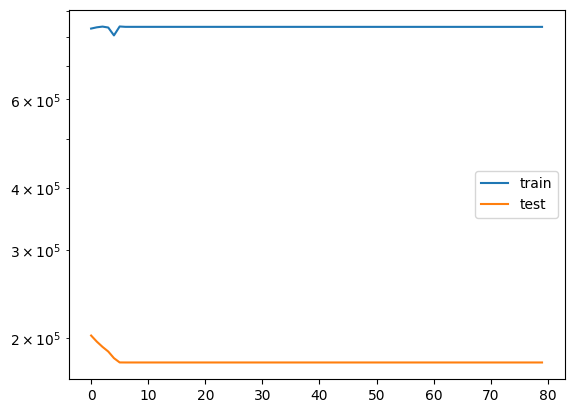

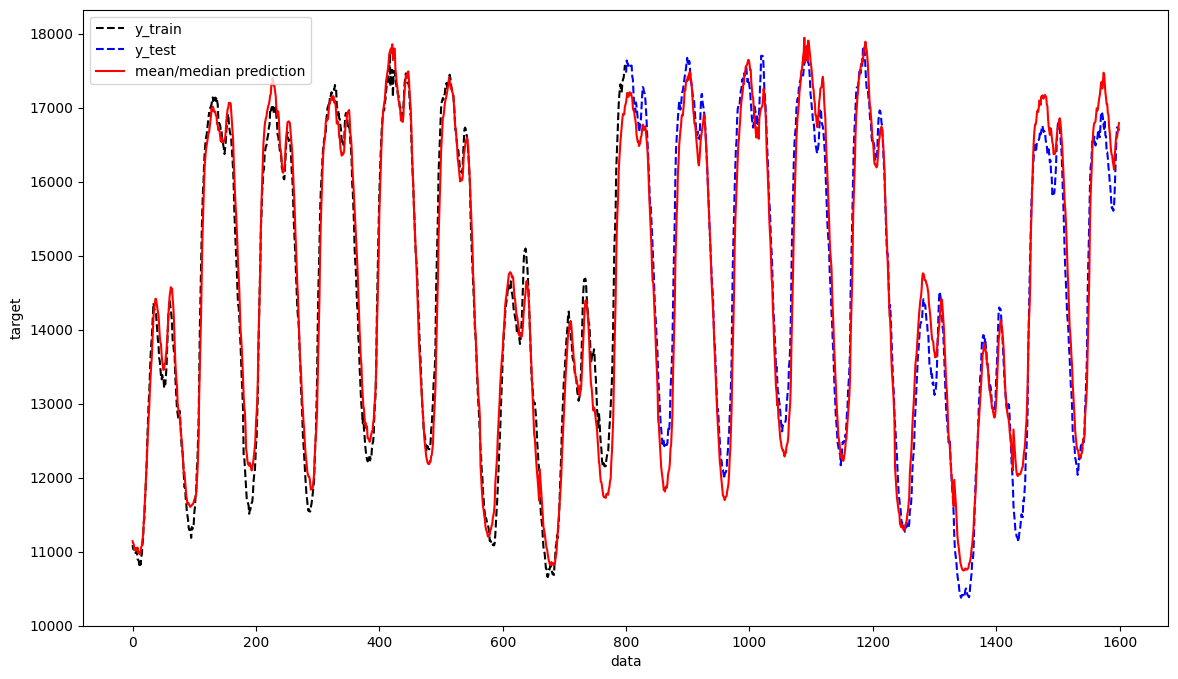

In [14]:
# TRAIN + PLOTS

import more_itertools

random_state = 711
N_EPOCHS = 1000
batch_size = 20

verbose = True
hidden_layer_size = 50
num_hidden_layers = 2
activation = torch.nn.LeakyReLU

train_loss_iter = N_EPOCHS // 100
test_loss_iter = train_loss_iter

lr = 0.1  # 1e-3


def train_base_model(n_epochs, hidden_layer_size, lr=0.1, val_frac=0.1, verbose=True):
    dim_in, dim_out = X_train.shape[-1], y_train.shape[-1]
    # try:
    #     X_test_tensor = df_to_tensor(X_test)
    # except AttributeError:
    #     X_test_tensor = X_test
    X_test_tensor = X_test
    val_size = round(val_frac * y_test.shape[0])
    X_val, y_val = X_test_tensor[:val_size], y_test[:val_size]

    model = model_builder(dim_in, hidden_layer_size, dim_out)

    train_loader = _get_train_loader(X_train, y_train, batch_size)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.1)

    iterable = tqdm(range(n_epochs)) if verbose else range(n_epochs)
    train_losses, test_losses = [], []
    for epoch in iterable:
        model.train()
        for loaded_X, loaded_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(loaded_X), loaded_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():  # todo: correct?
            val_loss = mse(model(X_val), y_val)
        scheduler.step(val_loss)

        try:
            if epoch % train_loss_iter == 0:
                train_losses.append(loss.item())
            if epoch % test_loss_iter == 0:
                model.eval()
                with torch.no_grad():
                    test_preds = model(X_test_tensor)  # .detach()
                test_loss = mse(test_preds, y_test).item()
                test_losses.append(test_loss)
        except ZeroDivisionError:
            pass
    model.eval()
    base_model = model
    return base_model, train_losses, test_losses

torch.manual_seed(random_state)

base_model, train_losses, test_losses = train_base_model(N_EPOCHS, hidden_layer_size, lr=lr, val_frac=0.1, verbose=True)
base_model.eval()

loss_skip = 20
plot_training_progress(train_losses[loss_skip:], test_losses[loss_skip:])


def test(X, base_model):
    X_input = X.detach()
    y_preds = base_model(X_input).detach()
    plot_base_performance(y_preds)

test(X, base_model)

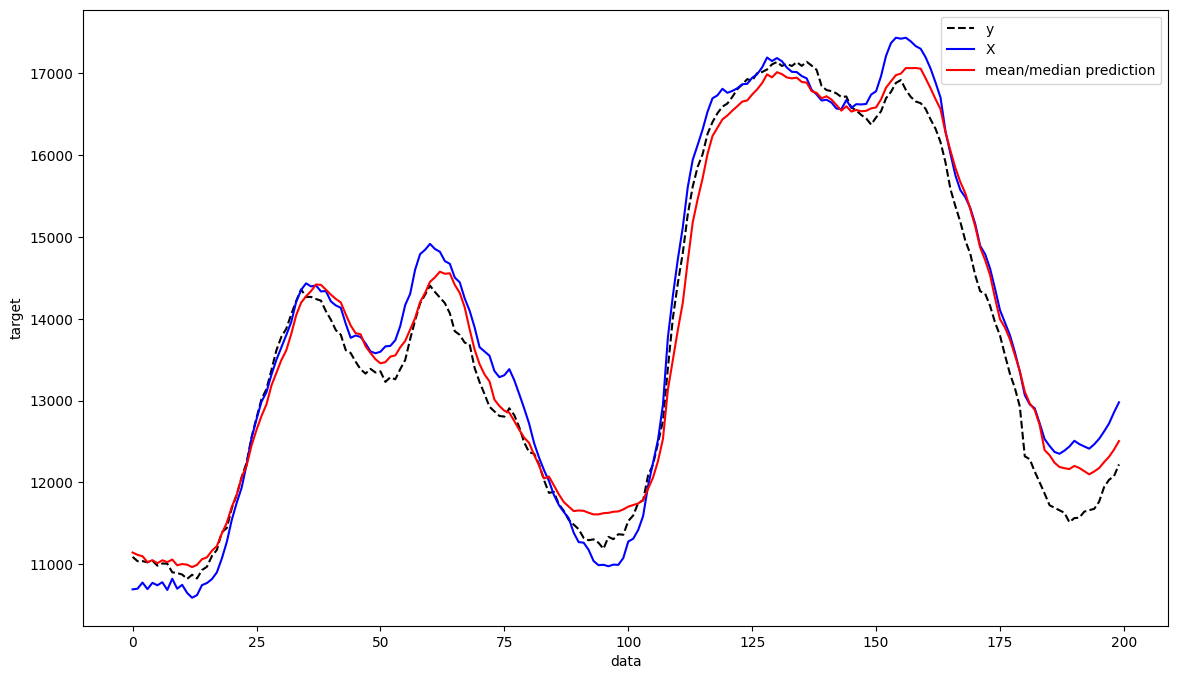

In [17]:
# PLOTS ONLY

def plot_base_performance2(y_preds):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    x_plot_uq = x_plot_full

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

    limstart = 0
    limend = 200
    # ax.plot(x_plot_train[-lim:], y_train[-lim:], label='y_train', linestyle="dashed", color="black")
    ax.plot(x_plot_train[limstart:limend], y_train[limstart:limend], label='y', linestyle="dashed", color="black")

    X_train2 = X_scaler.inverse_transform(X_train)
    ax.plot(x_plot_train[limstart:limend], X_train2[limstart:limend, -3], label='X', color="blue")

    # y_preds = y_preds[-y_test.shape[0]:]
    ax.plot(x_plot_train[limstart:limend], y_preds[limstart:limend], label=f"mean/median prediction", color="red")

    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")

    plt.show()


def test2(X, base_model):
    X_input = X.detach()
    y_preds = base_model(X_input).detach()
    plot_base_performance2(y_preds)


test2(X, base_model)